In [0]:
import numpy as np
#os hago el trabajo más duro

# Introducción 

La idea de la práctica es visitar aquellos temas que en cierta manera nos permitan ver más contenido del curso.

La práctica esta dividida en 4 o 5 subapartados, que ya tenéis en este mismo Notebook. Estos subapartados estan aquí para que rellenéis el código que hace falta para la realización de la práctica. Obviamente podéis usar tantas celdas como os hagan falta, es más es de agradecer si el código final esta algo "limpio". Usar funciones, algo de comentario, etc, etc...

Usaremos 2 datasets, uno para el primer ejercicio, y otro para el resto de ejercicios.

Ejercicios:


1.   Machine Learning vs Deep Learning (Acordaros que hay que implementar el pipeline visto en clase entero)

    1.1. Implementación de un modelo de Sentiment Analysis con algún algoritmo de Machine Learning Clásico.
    
    1.2. Implementación de un modelo de Sentiment Analysis con alguna arquitectura de Deep Learning.
    
    1.3. Breve Comparación de resultados. Confusion Matrix.
    
2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

3. Escoged a uno de los dos presidentes, y escribid tweets como ellos, usando un Modelo Generativo.

En cada ejercicio, espero explicaciones y razonamientos del porque una arquitectura y no otra, por ejemplo en Deep Learning, porque usar Convolutionals en lugar de recurrentes, o en Machine Learning, Bayes en lugar de SVM. Hay que explicar el pipeline, sobretodo el preproceso de datos, con lo que habrá que hacer un pequeño estudio de que datos tenemos, y si hay cosas que se pueden ignorar, si hacéis stemming, o no, etc, etc...

Acordaros de que objetivo final no es que obtengáis una accuracy brutal, es que comprendais que pasa cuando usais un algoritmo u otro, y que problemas o beneficios nos dan.

![](https://i.pinimg.com/736x/19/63/8c/19638c0b33e2f7822d6806ce31d89d84--funny-cartoons-funny-jokes.jpg)

Mucha suerte y ánimo!



# Dataset

Breve explicación del dataset

In [0]:
# !cat /proc/meminfo

# Práctica/Código a entregar

## Pre-train Sentiment Analysis Model

## Sentiment Analysis with Politics

In [0]:
#Code aquí

## Tweet Analysis

### Carga de librerías

In [1]:
!pip install gensim
!pip install pyLDAvis
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install stop_words

     |████████████████████████████████| 1.6MB 9.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=762cb5d539bc54be55538d75cad3fbdf46a1808f3bc78c66014d95483be3bd16
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=7f24d34fc66c080499222dea78870ed8a0f7af49422df1b6bb8a9871606f8f3e
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
import gensim
from os.path import join
import csv
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io

import warnings
warnings.filterwarnings('ignore')

### Datos

#### Preprocesado de datos

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

In [4]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset2.json to dataset2.json
User uploaded file "dataset2.json" with length 1070528 bytes


In [5]:
!ls

dataset2.json  sample_data


In [0]:
df = pd.read_json('dataset2.json', encoding = 'utf8')

In [44]:
df.head(5)
df = df.T
df.head(5)

,label,tweet
0,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
1,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
2,OBAMA,"This National Gun Violence Awareness Day, show..."
3,OBAMA,We can never truly repay the debt we owe our f...
4,OBAMA,This Center is for the leaders of tomorrow who...


In [0]:
# Obtenemos los documentos
documents = []
for row in df.iterrows():
    _, info = row
    _, tweet = info
    tweet = re.sub(r'\n', '', tweet)
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documents.append(tweet)


In [47]:
# Usamos Gensim para construir el diccionario

from gensim.corpora import Dictionary

gensim_dict = Dictionary(documents)
#gensim_dict.filter_extremes(no_below=2, no_above=0.3)

print('{} unique tokens'.format(len(gensim_dict)))

14375 unique tokens


In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

#### Implementamos usando Gensim

In [50]:
from gensim import corpora, models, similarities

lda_big = models.LdaModel(corpus, id2word=gensim_dict, num_topics=50, iterations=5, passes=20, alpha='auto')
print(lda_big.log_perplexity(corpus))

-8.656340539049467


In [0]:
lda_small = models.LdaModel(corpus, id2word=gensim_dict, num_topics=10, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(corpus))
vis = pyLDAvis.gensim.prepare(lda_small, corpus, gensim_dict)
pyLDAvis.display(vis)

-717588.2127751112


In [0]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, iterations=5):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=iterations, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
  

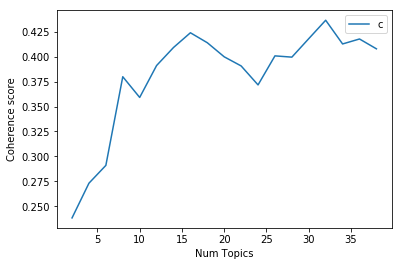

In [0]:

limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



Vemos como el número de topics óptimo estaría alrededor de los 32 - 33.

Como este entrenamiento lleva su tiempo y se pide de qué hablan unos y otros, vamos a repetir y optimizar el proceso para los tweets de forma individual, tanto para Obama como para Trump.

In [40]:

# Obtenemos los documentos de los políticos
def obtener_documentos(df, label):
    label_documents = []
    for row in df[df['label'] == label].iterrows():
        _, info = row
        _, tweet = info
        tweet = re.sub(r'\n', '', tweet)
        tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
        label_documents.append(tweet)
  
    return label_documents

obama_documents = obtener_documentos(df, 'OBAMA')
trump_documents = obtener_documentos(df, 'TRUMP')

print(r'Obama tweets #: {}'.format(len(obama_documents)))
print(r'Trump tweets #: {}'.format(len(trump_documents)))


Obama tweets #: 2894
Trump tweets #: 2995


In [52]:
# Usamos Gensim para construir el diccionario
from gensim.corpora import Dictionary

obama_gensim_dict = Dictionary(obama_documents)
trump_gensim_dict = Dictionary(trump_documents)

print('{} Obama unique tokens'.format(len(obama_gensim_dict)))
print('{} Trump unique tokens'.format(len(trump_gensim_dict)))

# Con tan pocas palabras, no merece la pena filtrar nada
# gensim_dict.filter_extremes(no_below=2, no_above=0.3)

obama_corpus = [obama_gensim_dict.doc2bow(doc) for doc in obama_documents]
trump_corpus = [trump_gensim_dict.doc2bow(doc) for doc in trump_documents]

7118 Obama unique tokens
9720 Trump unique tokens


Calculamos el número de temas, para los cuales la coherencia es máxima:

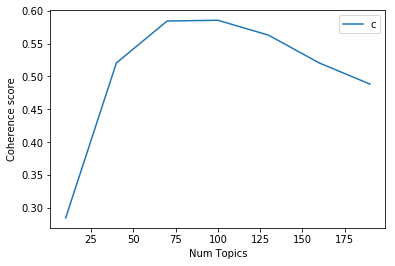

In [58]:
# Obama

limit=200; start=10; step=30;
model_list, coherence_values = compute_coherence_values(dictionary=obama_gensim_dict, corpus=obama_corpus, texts=obama_documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



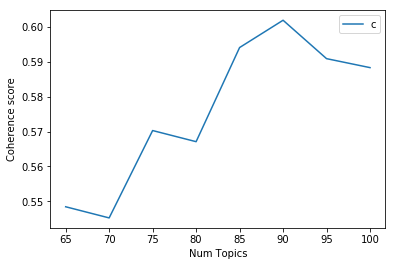

In [61]:
limit=105; start=65; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=obama_gensim_dict, corpus=obama_corpus, texts=obama_documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

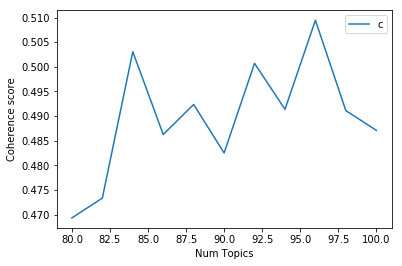

In [65]:
limit=102; start=80; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=obama_gensim_dict, corpus=obama_corpus, texts=obama_documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [67]:
lda_small = models.LdaModel(obama_corpus, id2word=obama_gensim_dict, num_topics=96, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(obama_corpus))
vis = pyLDAvis.gensim.prepare(lda_small, obama_corpus, obama_gensim_dict)
pyLDAvis.display(vis)

-450941.9877772331


Esta debería ser la solución óptima. Si nos preguntasen de una forma más relajada de qué habla, no parece operativo recopilar esta cantidad de temas, así que vamos a buscar otro valor de coherencia menor, pero que intente maximizar la clasificación de los tweets para ese número de temas. (Además, visualmente, muchos temas se pisan entre sí, por el lado derecho, vamos a ver si de paso, en la búsqueda de ese otro valor de coherencia podemos mejorar esto.)

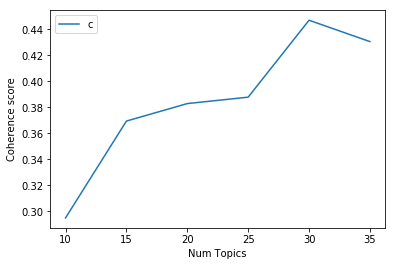

In [68]:
limit=40; start=10; step=5;
model_list, coherence_values = compute_coherence_values(dictionary=obama_gensim_dict, corpus=obama_corpus, texts=obama_documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Parece que tenemos un máximo local en 30

In [69]:
lda_small = models.LdaModel(obama_corpus, id2word=obama_gensim_dict, num_topics=30, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(obama_corpus))
vis = pyLDAvis.gensim.prepare(lda_small, obama_corpus, obama_gensim_dict)
pyLDAvis.display(vis)

-271005.1186839342


Probamos también con 15, valor donde la gráfica deja de crecer considerablemente.

In [70]:
lda_small = models.LdaModel(obama_corpus, id2word=obama_gensim_dict, num_topics=15, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(obama_corpus))
vis = pyLDAvis.gensim.prepare(lda_small, obama_corpus, obama_gensim_dict)
pyLDAvis.display(vis)

-265025.5000394583


Por tanto, si nos centramos en el valor de máxima coherencia, posiblemente el número de topics sea 96, y sí es cierto que salen temas más variados, a pesar de que visualmente haya círculos que se pisen unos con otros, y posiblemente el tema sea el mismo.




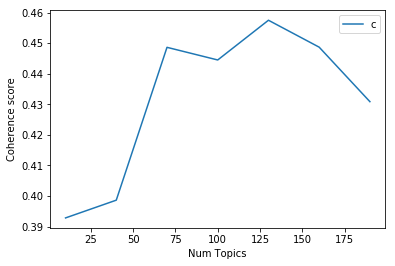

In [72]:
# Vamos con Trump

limit=200; start=10; step=30;
model_list, coherence_values = compute_coherence_values(dictionary=trump_gensim_dict, corpus=trump_corpus, texts=trump_documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

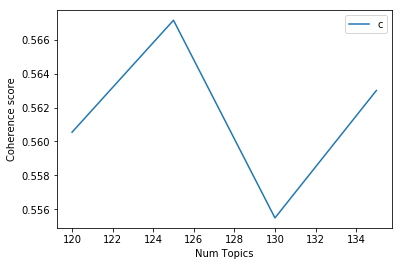

In [74]:
limit=140; start=120; step=5; iterations=1;
model_list, coherence_values = compute_coherence_values(dictionary=trump_gensim_dict, corpus=trump_corpus, texts=trump_documents, start=start, limit=limit, step=step, iterations=iterations)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

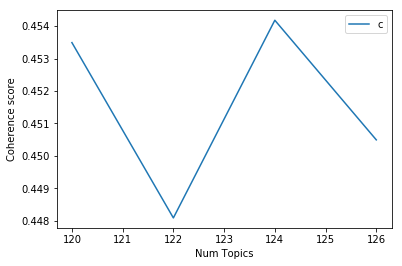

In [75]:
limit=128; start=120; step=2; iterations=5;
model_list, coherence_values = compute_coherence_values(dictionary=trump_gensim_dict, corpus=trump_corpus, texts=trump_documents, start=start, limit=limit, step=step, iterations=iterations)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Parece que el máximo de coherencia lo encontramos en 124

In [76]:
lda_small = models.LdaModel(trump_corpus, id2word=trump_gensim_dict, num_topics=124, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(trump_corpus))
vis = pyLDAvis.gensim.prepare(lda_small, trump_corpus, trump_gensim_dict)
pyLDAvis.display(vis)

-705572.9392833114


Vamos a ver, si podemos buscar algún otro máximo local con menor número de temas para intentar dar una visión resumida de los temas más tratados en los tweets de Trump

---



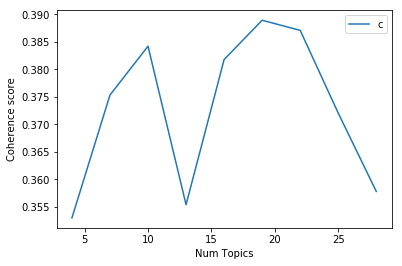

In [86]:
limit=30; start=4; step=3; iterations=5;
model_list, coherence_values = compute_coherence_values(dictionary=trump_gensim_dict, corpus=trump_corpus, texts=trump_documents, start=start, limit=limit, step=step, iterations=iterations)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

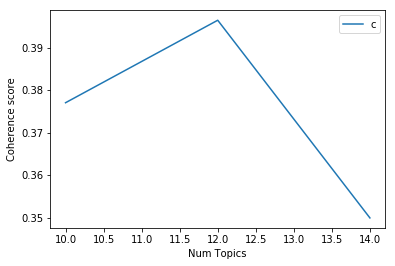

In [85]:
limit=16; start=10; step=2; iterations=5;
model_list, coherence_values = compute_coherence_values(dictionary=trump_gensim_dict, corpus=trump_corpus, texts=trump_documents, start=start, limit=limit, step=step, iterations=iterations)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [87]:
lda_small = models.LdaModel(trump_corpus, id2word=trump_gensim_dict, num_topics=12, iterations=5, passes=20, alpha='auto')
print(lda_small.bound(trump_corpus))
vis = pyLDAvis.gensim.prepare(lda_small, trump_corpus, trump_gensim_dict)
pyLDAvis.display(vis)

-439043.72038424015


Por tanto, se concluye que los valores máximos de coherencia se han conseguido con 96 temas para Obama y 124 para Trump. Donde se podría leer que Trump habla de temas más variados que Obama.

Para contar rápidamente de qué habla cada uno, se han buscado máximos locales de coherencia y facilitarme la enumeración de algunos temas.


Obama
- Obama Presidente
- Sanidad
- Contaminación
- Garland candidato al Tribunal Supremo
- Cambio climático
- Mayor ocupación laboral
- Inmigración
- Clase media
- Subida del salario mínimo
- Demasiada violencia

Trump
- Obama. Fronteras. DACA.
- Noticias falsas
- Comercio Korea del norte, China
- Bajada de impuestos
- Votos de los republicanos
- Condolencias a Theresa May por el ataque terrorista en UK.
- America primero
- Trabajo
- "Make America great again"




## Tweet Generation

In [0]:
#Code aquí .